In [25]:
## Neccessary Imports

import pandas as pd
import numpy as np

import re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Attention, Dropout, GlobalMaxPooling1D, Concatenate, Flatten 
from tensorflow.keras.models import Model

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [26]:
data = pd.read_csv("twitter-suicidal_data.csv")  # adjust filename as per your dataset
data.head()


,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Cleaning

In [27]:
# Download NLTK resources 
nltk.download('stopwords')
nltk.download('wordnet')

# Function for data cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaidi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vaidi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
# Apply data cleaning to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(clean_text)
data.head()

,tweet,intention,cleaned_tweet
0,my life is meaningless i just want to end my l...,1,life meaningless want end life badly life comp...
1,muttering i wanna die to myself daily for a fe...,1,muttering wanna die daily month feel worthless...
2,work slave i really feel like my only purpose ...,1,work slave really feel like purpose life make ...
3,i did something on the 2 of october i overdose...,1,something october overdosed felt alone horribl...
4,i feel like no one cares i just want to die ma...,1,feel like one care want die maybe feel le lonely


## Data Preprocessing and Data Spliting

In [29]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(data['cleaned_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [30]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['intention'], test_size=0.25, random_state=42)

## Model Build and Training

In [31]:
max_sequence_length = 100
embedding_dim = 50
lstm_units = 64
dense_units = 32
num_filters = 64
kernel_size = 3

input_layer = Input(shape=(max_sequence_length,), name='Input')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim)(input_layer)
bilstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(bilstm_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)
dense_layer = Dense(dense_units, activation='relu')(pooling_layer)
output_layer = Dense(1, activation='sigmoid', name='Output')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 50)           1096250   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 128)          58880     
 onal)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            24640     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 32)                2080

In [32]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15


c:\Users\vaidi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


171/171 [==============================] - 22s 98ms/step - loss: 0.3528 - accuracy: 0.8572 - val_loss: 0.2464 - val_accuracy: 0.9145
Epoch 2/15
171/171 [==============================] - 17s 97ms/step - loss: 0.1864 - accuracy: 0.9373 - val_loss: 0.2453 - val_accuracy: 0.9159
Epoch 3/15
171/171 [==============================] - 17s 97ms/step - loss: 0.1234 - accuracy: 0.9591 - val_loss: 0.2657 - val_accuracy: 0.9094
Epoch 4/15
171/171 [==============================] - 17s 100ms/step - loss: 0.0751 - accuracy: 0.9742 - val_loss: 0.2985 - val_accuracy: 0.9079
Epoch 5/15
171/171 [==============================] - 16s 92ms/step - loss: 0.0503 - accuracy: 0.9814 - val_loss: 0.4056 - val_accuracy: 0.9086
Epoch 6/15
171/171 [==============================] - 16s 95ms/step - loss: 0.0303 - accuracy: 0.9883 - val_loss: 0.3894 - val_accuracy: 0.9072
Epoch 7/15
171/171 [==============================] - 15s 90ms/step - loss: 0.0268 - accuracy: 0.9899 - val_loss: 0.4817 - val_accuracy: 0.8911
Ep

## Plot the curve

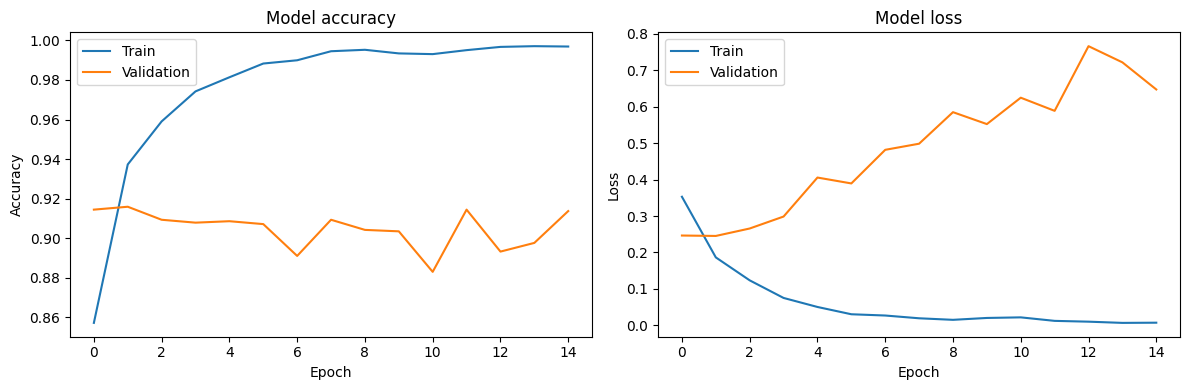

In [33]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

72/72 [==============================] - 3s 29ms/step


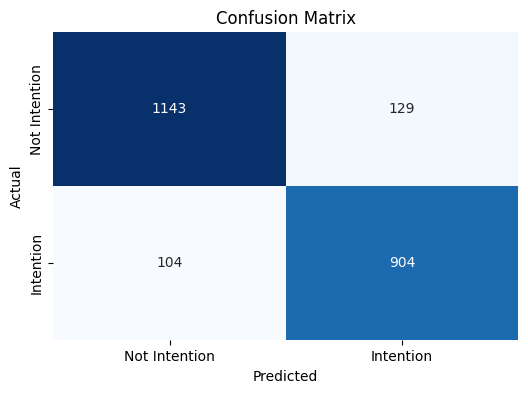

Accuracy Score: 0.8978070175438596
Precision Score: 0.8751210067763795


In [34]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

y_pred_classes = [1 if pred[0] > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Intention', 'Intention'], yticklabels=['Not Intention', 'Intention'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy score
print(f"Accuracy Score: {accuracy}")
# Print precision score
print(f"Precision Score: {precision}")

## Prediction

In [35]:
# Find the optimal threshold from the validation set
thresholds = np.arange(0.1, 0.3, 0.02)
# Find the threshold that maximizes F1-score on the validation set
best_threshold = 0.5  # Default threshold
best_f1_score = 0.0

for threshold in thresholds:
    y_pred_classes = [1 if pred > threshold else 0 for pred in y_pred.ravel()]
    current_f1_score = f1_score(y_test, y_pred_classes[:len(y_test)])  # Ensure length consistency
    
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold
# Print the best threshold and F1-score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1_score}")

Best Threshold: 0.26
Best F1-Score: 0.8864077669902912


In [38]:
# Example of a new tweet for prediction
new_tweet = ["i am 16 and hate myself so much i have very little friends an introvert never had a girlfriend been bullied a lot and rejected a lot please help me i dont deserve to be on this earth"]
happy = ["it is a very wonderfull day to start new work"]
# I wish i were dead. I wish I had not been born.i am 16 and hate myself so much i have very little friends an introvert never had a girlfriend been bullied a lot and rejected a lot please help me i dont deserve to be on this earth
# Clean the new tweet
cleaned_new_tweet = clean_text(new_tweet[0])
cleaned_happy_tweet =clean_text(happy[0])

# Tokenize and pad the sequence
new_sequence = tokenizer.texts_to_sequences([cleaned_new_tweet])
padded_new_sequence = pad_sequences(new_sequence, maxlen=100, padding='post', truncating='post')

happy_sequence = tokenizer.texts_to_sequences([cleaned_happy_tweet])
padded_happy_sequence = pad_sequences(happy_sequence, maxlen=100, padding='post', truncating='post')

# Make predictions
prediction = model.predict(padded_new_sequence)
prediction1 = model.predict(padded_happy_sequence)

# Interpret the prediction
prediction_class = 1 if prediction[0][0] > best_threshold else 0
prediction1_class = 1 if prediction1[0][0] > best_threshold else 0

# Display the result
print(f"Predicted Probability: {prediction[0][0]}")
print(f"Predicted Class: {'Intention' if prediction_class == 1 else 'Not Intention'}")

print(f"Predicted Probability: {prediction1[0][0]}")
print(f"Predicted Class: {'Intention' if prediction1_class == 1 else 'Not Intention'}")


1/1 [==============================] - 0s 45ms/step
Predicted Probability: 4.993900074623525e-05
Predicted Class: Not Intention
Predicted Probability: 2.891844417263201e-07
Predicted Class: Not Intention


In [37]:
# Evaluate the initial model on the test set
model_evaluation = model.evaluate(X_test, y_test)
print(f'Initial Model - Test Accuracy: {model_evaluation[1]:.4f}')

72/72 [==============================] - 2s 30ms/step - loss: 0.7156 - accuracy: 0.8978
Initial Model - Test Accuracy: 0.8978
